In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import lightgbm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import scipy
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv", parse_dates = ['Datetime'])
df_test = pd.read_csv("test.csv", parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('SampleSubmission.csv')

In [3]:
df_train.head(5)

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [4]:
df_train.shape

(297177, 7)

In [5]:
df_test.shape

(127361, 6)

In [6]:
df_train.describe(include="all")

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177,297177,293563.000000,293563.000000,293628.000000,293628.000000,297177.000000
unique,297177,293751,NaN,NaN,NaN,NaN,NaN
top,ID_QF0ZTQJ2SF5Q,2021-11-26 17:23:00,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-10-15 16:00:31,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-01-21 07:34:57,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.751195,38.183018,23.316554,78.653623,0.371072
std,NaN,NaN,28.526182,28.647761,3.836971,14.772725,0.483092
min,NaN,NaN,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,NaN,NaN,22.430000,19.520000,20.400000,68.000000,0.000000


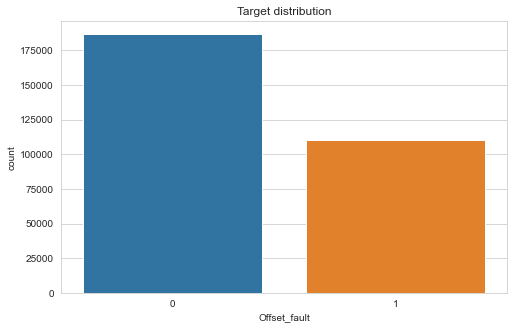

In [7]:
# Target variable distribution
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.countplot(df_train["Offset_fault"])
plt.title('Target distribution')
plt.show()

In [8]:
df_train.isnull().sum().sort_values(ascending=False)

Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
ID                      0
Datetime                0
Offset_fault            0
dtype: int64

In [9]:
def checkNull_fillData(df):
    for col in df.columns:
        if len(df.loc[df[col].isnull() == True]) != 0:
            if df[col].dtype == "float64" or df[col].dtype == "int64":
                df.loc[df[col].isnull() == True,col] = df[col].mean()
            else:
                df.loc[df[col].isnull() == True,col] = df[col].mode()[0]
checkNull_fillData(df_train)
checkNull_fillData(df_test)

In [10]:
df_test.isnull().sum().sort_values(ascending=False)

ID                   0
Datetime             0
Sensor1_PM2.5        0
Sensor2_PM2.5        0
Temperature          0
Relative_Humidity    0
dtype: int64

In [11]:
#Datetime format
# Extract day, month year and hour from the Datetime column
df_train['Datetime_year'] = df_train.Datetime.dt.year
df_train['Datetime_day'] = df_train.Datetime.dt.day
df_train['Datetime_hour'] = df_train.Datetime.dt.hour
df_train['Datetime_month'] = df_train.Datetime.dt.month


# Preview engineered date features
df_train[['Datetime', 'Datetime_day', 'Datetime_month', 'Datetime_year', 'Datetime_hour']].head()

,Datetime,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,2021-11-03 04:06:31,3,11,2021,4
1,2021-11-08 18:43:23,8,11,2021,18
2,2021-11-07 09:50:33,7,11,2021,9
3,2022-01-01 18:55:15,1,1,2022,18
4,2021-11-05 22:23:48,5,11,2021,22


In [12]:
df_test['Datetime_year'] = df_test.Datetime.dt.year
df_test['Datetime_day'] = df_test.Datetime.dt.day
df_test['Datetime_hour'] = df_test.Datetime.dt.hour
df_test['Datetime_month'] = df_test.Datetime.dt.month
df_test[['Datetime', 'Datetime_day', 'Datetime_month', 'Datetime_year', 'Datetime_hour']].head()

,Datetime,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,2022-01-28 08:49:41,28,1,2022,8
1,2022-02-16 21:30:17,16,2,2022,21
2,2022-01-24 17:57:18,24,1,2022,17
3,2022-01-31 07:07:09,31,1,2022,7
4,2022-01-31 00:37:05,31,1,2022,0


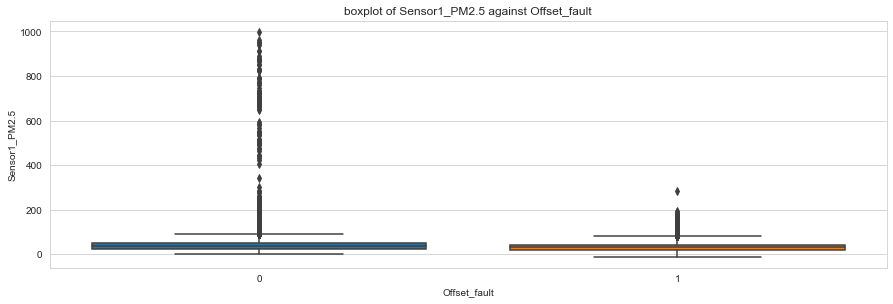

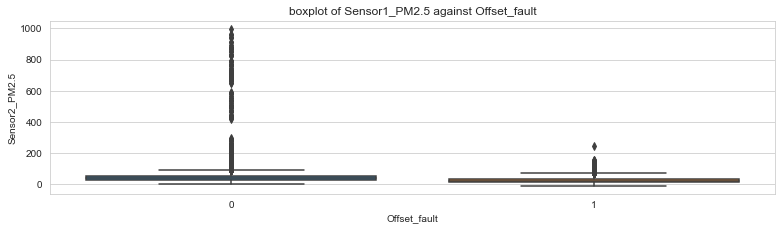

In [13]:
# using a boxplot to visualize outliers
plt.figure(figsize=(15,10))
plt.subplot(2,1,2)
sns.boxplot(df_train.Offset_fault, df_train["Sensor1_PM2.5"])
plt.title("boxplot of Sensor1_PM2.5 against Offset_fault")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sns.boxplot(df_train.Offset_fault, df_train['Sensor2_PM2.5'])
plt.title("boxplot of Sensor1_PM2.5 against Offset_fault")
plt.show()

In [14]:
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lwr_bound = q1 - (1.5*IQR)
    upp_bound = q3 + (1.5*IQR)
    for i in data:
        if(i<lwr_bound or i>upp_bound):
            outliers.append(i)
    return outliers
sample_outliers1 = detect_outliers_iqr(df_train["Sensor1_PM2.5"])
         

In [15]:
q1 = np.percentile(df_train["Sensor1_PM2.5"], 25)
q3 = np.percentile(df_train["Sensor1_PM2.5"], 75)
IQR = q3-q1
lwr_bound = q1 - (1.5*IQR)
upp_bound = q3 + (1.5*IQR)

df_train["Sensor1_PM2.5a"] = np.where(df_train["Sensor1_PM2.5"]>upp_bound, upp_bound,
                             np.where(df_train["Sensor1_PM2.5"]<lwr_bound, lwr_bound,
                                      df_train["Sensor1_PM2.5"]))

In [16]:
q1 = np.percentile(df_train["Sensor2_PM2.5"], 25)
q3 = np.percentile(df_train["Sensor2_PM2.5"], 75)
IQR = q3-q1
lwr_bound = q1 - (1.5*IQR)
upp_bound = q3 + (1.5*IQR)

df_train["Sensor2_PM2.5a"] = np.where(df_train["Sensor2_PM2.5"]>upp_bound, upp_bound,
                             np.where(df_train["Sensor2_PM2.5"]<lwr_bound, lwr_bound,
                                      df_train["Sensor2_PM2.5"]))

In [17]:
q1 = np.percentile(df_test["Sensor1_PM2.5"], 25)
q3 = np.percentile(df_test["Sensor1_PM2.5"], 75)
IQR = q3-q1
lwr_bound = q1 - (1.5*IQR)
upp_bound = q3 + (1.5*IQR)

df_test["Sensor1_PM2.5a"] = np.where(df_test["Sensor1_PM2.5"]>upp_bound, upp_bound,
                             np.where(df_test["Sensor1_PM2.5"]<lwr_bound, lwr_bound,
                                      df_test["Sensor1_PM2.5"]))

In [18]:
q1 = np.percentile(df_test["Sensor2_PM2.5"], 25)
q3 = np.percentile(df_test["Sensor2_PM2.5"], 75)
IQR = q3-q1
lwr_bound = q1 - (1.5*IQR)
upp_bound = q3 + (1.5*IQR)

df_test["Sensor2_PM2.5a"] = np.where(df_test["Sensor2_PM2.5"]>upp_bound, upp_bound,
                             np.where(df_test["Sensor2_PM2.5"]<lwr_bound, lwr_bound,
                                      df_test["Sensor2_PM2.5"]))

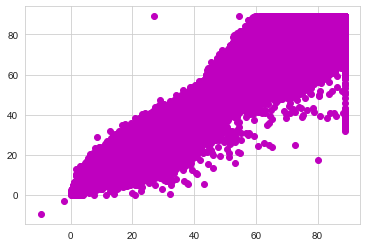

In [19]:
np.mean(df_train["Sensor1_PM2.5a"])
np.mean(df_train["Sensor2_PM2.5a"])
plt.scatter(df_train["Sensor2_PM2.5a"], df_train["Sensor1_PM2.5a"], color="m")

In [20]:
my_cols = ['Sensor1_PM2.5a','Sensor2_PM2.5a','Temperature','Relative_Humidity','Datetime_day',
               'Datetime_month','Datetime_year','Datetime_hour']
y=df_train.Offset_fault
df_train = df_train[my_cols]

In [21]:
#numeric_cols = [col for col in df_train.columns if df_train[col].dtype == "float64" or df_train[col].dtype == "int64"]
#poly = PolynomialFeatures(degree=0.5, interaction_only=True, include_bias=False)
#df_train_poly = poly.fit_transform(df_train[numeric_cols])
#df_test_poly =  poly.fit_transform(df_test[numeric_cols])
#df_train = pd.DataFrame(df_train_poly, columns = [f"poly_{i}" for i in range(df_train_poly.shape[1])])
#df_test = pd.DataFrame(df_test_poly, columns = [f"poly_{i}" for i in range(df_test_poly.shape[1])])

In [22]:
df_train

,Sensor1_PM2.5a,Sensor2_PM2.5a,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,52.580,49.52,17.4,96.0,3,11,2021,4
1,35.250,33.40,25.0,75.0,8,11,2021,18
2,19.180,23.50,24.9,75.0,7,11,2021,9
3,19.400,15.48,24.9,70.0,1,1,2022,18
4,38.300,34.77,20.9,89.0,5,11,2021,22
...,...,...,...,...,...,...,...,...
297172,36.400,37.77,28.6,62.0,19,11,2021,12
297173,50.120,40.63,21.6,86.0,22,11,2021,1
297174,53.680,45.23,20.2,94.0,5,11,2021,1
297175,89.075,88.90,20.6,93.0,23,11,2021,22


In [23]:
#break of validation set from training data
n_folds=5
test_data_array=[]
predictions_array=[]
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_train, y, train_size=0.7,
                                                                test_size=0.3, random_state=2045)
model = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.05, eval_metric = "logloss", random_state=42)
#model = lightgbm.LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42, objective = 'binary', metric = 'binary_logloss')
for fold in range (0, n_folds):
    over = SMOTE(sampling_strategy = 0.7)
    under = RandomUnderSampler(sampling_strategy = 0.7)
    #("u", under)
    steps = [("o", over), ("model", model)]
    pipeline = Pipeline(steps=steps)

    X_train = X_train_full[my_cols].copy()
    X_valid = X_valid_full[my_cols].copy()
    X_test = df_test[my_cols].copy()
    X_train, X_valid = X_train.align(X_valid, join="left", axis=1)
    #fit the model 
    pipeline.fit(X_train, y_train)
    predictions =pipeline.predict(X_valid)
    test_data_array = test_data_array + y_valid.tolist()
    predictions_array = predictions_array + predictions.tolist()
    print(f'Accuracy score: {accuracy_score(y_valid, predictions)}')
print(classification_report(y_true = test_data_array,y_pred =predictions_array))
    


Accuracy score: 0.951084640061018
Accuracy score: 0.951084640061018
Accuracy score: 0.9508154429414272
Accuracy score: 0.9513650537272584
Accuracy score: 0.951376270273908
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    281270
           1       0.93      0.94      0.93    164500

    accuracy                           0.95    445770
   macro avg       0.95      0.95      0.95    445770
weighted avg       0.95      0.95      0.95    445770



In [24]:
#Classifier = lightgbm.LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
help(lightgbm.LGBMClassifier())

Help on LGBMClassifier in module lightgbm.sklearn object:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable, NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None, n_jobs: int = -1, silent: Union[bool, str] = 'warn', importance_type: str = 'split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      sklearn.base.ClassifierMixin
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Me

In [25]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(208023, 8)
(89154, 8)
(127361, 8)


In [26]:
#pipeline.fit(X_train, y_train)

In [27]:
predictions_1 = pipeline.predict(X_valid)
print(f'Accuracy score: {accuracy_score(y_valid, predictions_1)}')
print('\n')
print(f'{classification_report(y_valid, predictions_1)}')

Accuracy score: 0.951376270273908


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     56254
           1       0.93      0.94      0.93     32900

    accuracy                           0.95     89154
   macro avg       0.95      0.95      0.95     89154
weighted avg       0.95      0.95      0.95     89154



In [28]:
data={"Offset_value":predictions_1}
pred = pd.DataFrame(data)
pred.head(5)

,Offset_value
0,0
1,0
2,0
3,0
4,0


In [29]:
pred["Offset_value"].value_counts()

0    56047
1    33107
Name: Offset_value, dtype: int64

In [30]:
X_test.shape

(127361, 8)

In [31]:
'''clf = RandomForestClassifier(max_depth = 3, random_state = 0)
clf.fit(X_train, y_train)
predictions_2 = clf.predict(X_valid)
print(f'Accuracy score: {accuracy_score(y_valid, predictions_2)}')
print('\n')
print(f'{classification_report(y_valid, predictions_2)}')'''

"clf = RandomForestClassifier(max_depth = 3, random_state = 0)\nclf.fit(X_train, y_train)\npredictions_2 = clf.predict(X_valid)\nprint(f'Accuracy score: {accuracy_score(y_valid, predictions_2)}')\nprint('\n')\nprint(f'{classification_report(y_valid, predictions_2)}')"

In [32]:
''''data={"Offset_value":predictions_2}
pred1 = pd.DataFrame(data)
pred1["Offset_value"].value_counts()'''

'\'data={"Offset_value":predictions_2}\npred1 = pd.DataFrame(data)\npred1["Offset_value"].value_counts()'

In [33]:
#cross validation, feature imbalance, missing data, feature engineering

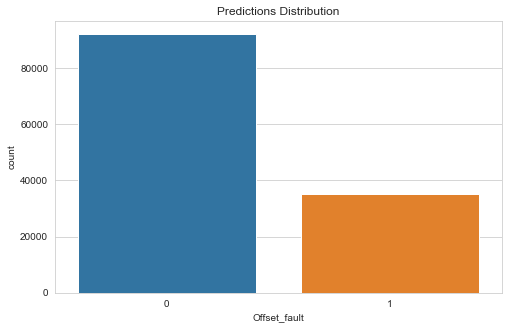

In [34]:
# Make prediction on the test set
test = df_test[my_cols]
predictions = pipeline.predict(test)

submission_file = samplesubmission.copy()
submission_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(submission_file.Offset_fault)
plt.title('Predictions Distribution');

In [35]:
submission_file.to_csv('Submission7.csv', index = False)